# Week 2 - Sampling & Reliability

Wanitchaya Poonpatanapricha

**I work on this notebook as an extension of HW3, where I extrapolated some unannotated data. That is instead of comparing codes by human annotators, I want to see if the methods in this notebook also work with comparing extrapolations by different classification models. Would these methods be able to favor models that performed better during the train-test sessions? Would it be appropriate to obtain the final, best extrapolated values by treating these models as annotators?**

*NOTE: This notebook will make a lot more sense if you read this after my HW3 notebook which have already been uploaded*

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
I want to investigate whether emoji are used to serve functions related to politeness in computer-mediated communications (CMCs). For example:

> Could you redo your report? :)

I speculate that speaker of a language with more polite elements (such as honorifics in Japanese, polite final particles in Thai) would use emoji for polite purpose more when that speaker has to CMCing in English (since English doesn't have as rich of polite elements).

I scraped a CMC in English from one discord which asks its users to tag themselves with their primary languages. Some users, however, did not do so, so I try to extrapolate these users' primary languages through supervised classification.

## ***Why?***
Emoji are very prevalent in CMCs these days. However, there are not that many research on the functions of emoji other than expressing direct emotions. It is important to understand these other functions of emoji in communication as well as any cultural differences. CMCs suffer from the lack of non-verbal cues and hence there are a lot of miscommunication. Understanding emoji better, which is in some ways a representative of non-verbal cues, could help us understand CMCs and miscommunication issues better!

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

The goal of is to investigate whether a speaker whose primary language has higher degree of politeness (than English) is more likely to use emoji as elements of politeness when the speaker has to communicate politely in English.

To do so, an ideal dataset would be a CMC which requires politeness, is in English, has emoji, and is a product of speakers with different primary languages. In addition, those languages should have varied degrees of politeness relative to English, and each language's degree of politeness could be clearly classified. If the hypothesis of this paper is correct, ESL speakers whose primary languages have high degrees of politeness should use emoji more than ESL speakers whose primary languages have lower degrees of politeness.

In this paper, the next best ideal data is used because it is not feasible to conduct a carefully controlled experiment. In particular, the dataset will be approximated from a CMC in English with emoji which some speakers' primary languages are known. The politeness distinctions in pronouns feature from WALS will be used as a proxy for each language's degree of politeness. Lastly, dialogue act (DA), which will be automatically classified by a classifier trained on a corpus with known DA tags, will be used as a proxy for politeness.

# Annotation Statistics

## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [83]:
tsuki = pandas.read_csv("tsuki_extrapolate.csv")
tsuki = tsuki.iloc[:,-7:]
tsuki_anno = tsuki.replace(['east','sea','eu'], [0,1,2])
tsuki_anno = tsuki_anno.rename_axis('ID').values
tsuki_anno

array([[2, 2, 0, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [84]:
tsuki.columns

Index(['logit_predict', 'Mnb_predict', 'tree_predict', 'rf_predict',
       'bg_predict', 'knn_predict', 'nn_predict'],
      dtype='object')

In [85]:
anno = AnnotationsContainer.from_array(tsuki_anno)

In [86]:
pyanno.measures.agreement.labels_frequency(anno.annotations,3)

array([0.85772328, 0.09533483, 0.04694188])

Seems like all models only agree on the value 'east'...

Let's exclude some models that I know are bad from HW 3.

In [87]:
tsuki_small = tsuki.iloc[:,[0,1,3,6]]
tsuki_anno = tsuki_small.replace(['east','sea','eu'], [1,2,3])
tsuki_anno = tsuki_anno.rename_axis('ID').values
tsuki_small.columns

Index(['logit_predict', 'Mnb_predict', 'rf_predict', 'nn_predict'], dtype='object')

In [88]:
anno = AnnotationsContainer.from_array(tsuki_anno, missing_values=[-1])

In [89]:
pyanno.measures.agreement.labels_frequency(anno.annotations,3)

array([0.79024886, 0.13420518, 0.07554596])

Now it is slightly better on 'sea' and 'eu', but still not much...

Extrapolation agreements between **Random forest** and **Neural net**

[[1095.  221.   94.]
 [ 101.  191.   31.]
 [  56.   44.  136.]]


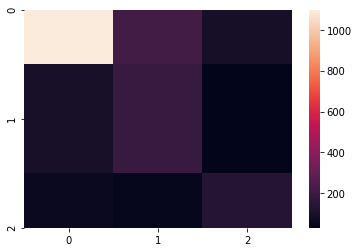

In [90]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,2], anno.annotations[:,3],3)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [91]:
scotts_pi(anno.annotations[:,2], anno.annotations[:,3])

0.430719566581877

In [92]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.6920586524323042

Now let's see the average across all four models.

In [93]:
fleiss_kappa(anno.annotations[::])

0.3426418303621165

In [94]:
krippendorffs_alpha(anno.annotations[::])

0.35497924394491887

In [95]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.3816961584128495

In [96]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.3913041570218418

Seems like Random forest and Neural net agree with each other more than the average agreement among 4 models. Let's see all pairwise agreements.

In [97]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.69205865 0.29678681 0.25326095]
 [0.69205865 1.         0.31924106 0.29487286]
 [0.29678681 0.31924106 1.         0.43395662]
 [0.25326095 0.29487286 0.43395662 1.        ]]


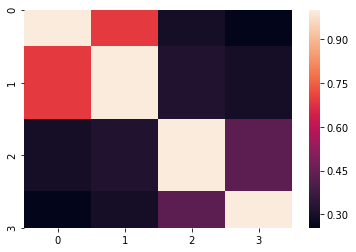

In [98]:
ax = seaborn.heatmap(m)
plt.show()

So **Logistic regression** and **Multinomial NB** agree well with each other too. But both of them does not agree well with **Random forest** and **Neural net**.

It actually doesn't make sense to treat these labels as real value, but I will try for fun anyway~

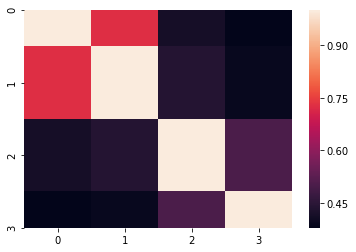

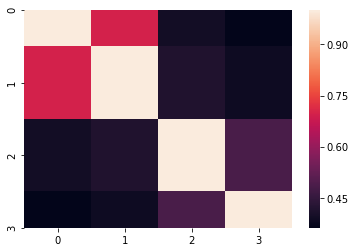

In [99]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [100]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.4748916876359077 0.4567687100384246


It is pretty much the same pattern with treating the labels as categorical. 

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

# Models

Let's bring all models back (including the bad ones!)

In [122]:
tsuki = pandas.read_csv("tsuki_extrapolate.csv")
tsuki = tsuki.iloc[:,-7:]
tsuki_anno = tsuki.replace(['east','sea','eu'], [0,1,2])
tsuki_anno = tsuki_anno.rename_axis('ID').values

In [117]:
tsuki.columns

Index(['logit_predict', 'Mnb_predict', 'tree_predict', 'rf_predict',
       'bg_predict', 'knn_predict', 'nn_predict'],
      dtype='object')

In [118]:
anno = AnnotationsContainer.from_array(tsuki_anno)

In [123]:
model = ModelB.create_initial_state(3, 7)

In [120]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [124]:
model.map(anno.annotations)

In [125]:
posterior = model.infer_labels(anno.annotations)

In [127]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

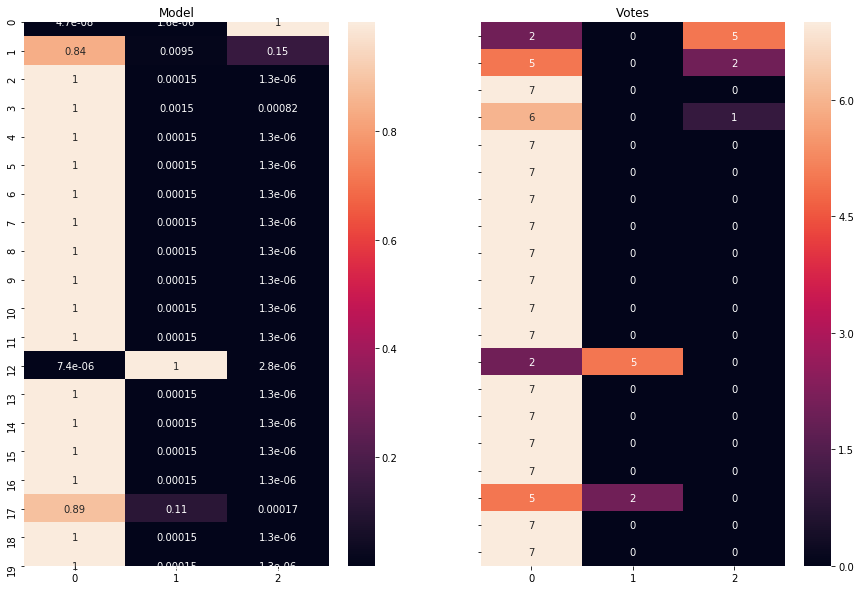

In [128]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

Most models seems to agree in mose cases! There aren't many ties to break... Which could be both good and bad. All models may be wrong in the same way :(

Let's try everything again with ModelBt

In [131]:
model = ModelBt.create_initial_state(3, 7)
model.map(anno.annotations)
posterior = model.infer_labels(anno.annotations)

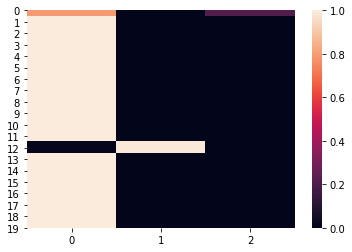

In [133]:
ax = seaborn.heatmap(posterior[:20,])
plt.show()

We can easily see that inferring from these models really prefer 'east' over other labels.

In [135]:
model = ModelBt.create_initial_state(3, 7)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

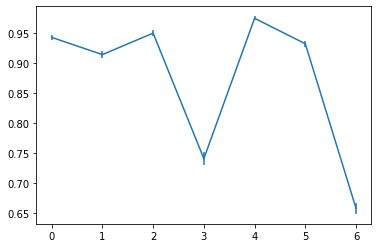

In [136]:
plt.figure()
plt.errorbar(range(7),y, yerr = y_ci)
plt.show()

Seems like **Random Forest** and **Neural Net** have the worst accuracy even though they perform better (according to HW3)... Maybe we should not treat models the same as we treat annotators...?

Let's try all these again without the bad models...

In [137]:
tsuki_small = tsuki.iloc[:,[0,1,3,6]]
tsuki_anno = tsuki_small.replace(['east','sea','eu'], [1,2,3])
tsuki_anno = tsuki_anno.rename_axis('ID').values
tsuki_small.columns

Index(['logit_predict', 'Mnb_predict', 'rf_predict', 'nn_predict'], dtype='object')

In [138]:
anno = AnnotationsContainer.from_array(tsuki_anno, missing_values=[-1])

In [139]:
model = ModelB.create_initial_state(3, 4)

In [140]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [141]:
model.map(anno.annotations)

In [142]:
posterior = model.infer_labels(anno.annotations)

In [143]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

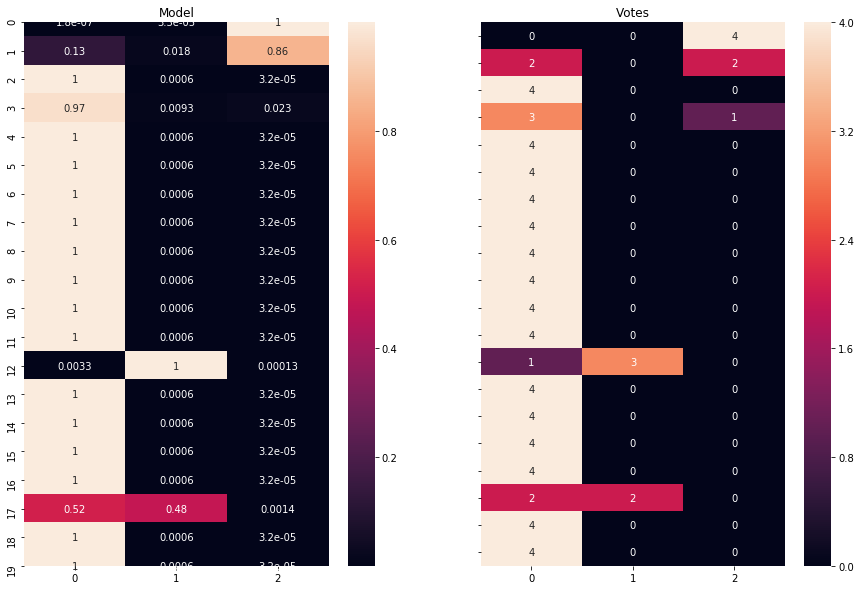

In [144]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

Now there are more ties to break!

Let's try everything again with ModelBt

In [145]:
model = ModelBt.create_initial_state(3, 4)
model.map(anno.annotations)
posterior = model.infer_labels(anno.annotations)

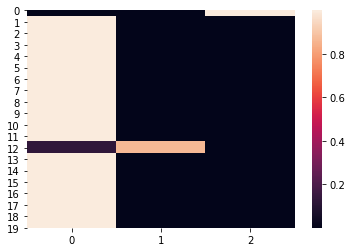

In [146]:
ax = seaborn.heatmap(posterior[:20,])
plt.show()

In [148]:
model = ModelBt.create_initial_state(3, 4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

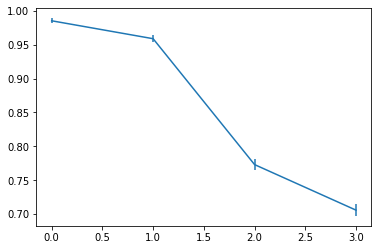

In [151]:
plt.figure()
plt.errorbar(range(4),y, yerr = y_ci)
plt.show()

Still, we can see **Random Forest** and **Neural Net** are not recognized as the most accurate...

And finally, just for fun, let's excluding only best models: **Random Forest** and **Neural Net**.

In [161]:
tsuki_small = tsuki.iloc[:,[0,1,2,4,5]]
tsuki_anno = tsuki_small.replace(['east','sea','eu'], [1,2,3])
tsuki_anno = tsuki_anno.rename_axis('ID').values
tsuki_small.columns

Index(['logit_predict', 'Mnb_predict', 'tree_predict', 'bg_predict',
       'knn_predict'],
      dtype='object')

In [162]:
anno = AnnotationsContainer.from_array(tsuki_anno, missing_values=[-1])

In [163]:
model = ModelB.create_initial_state(3, 5)

In [164]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [165]:
model.map(anno.annotations)

In [166]:
posterior = model.infer_labels(anno.annotations)

In [167]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

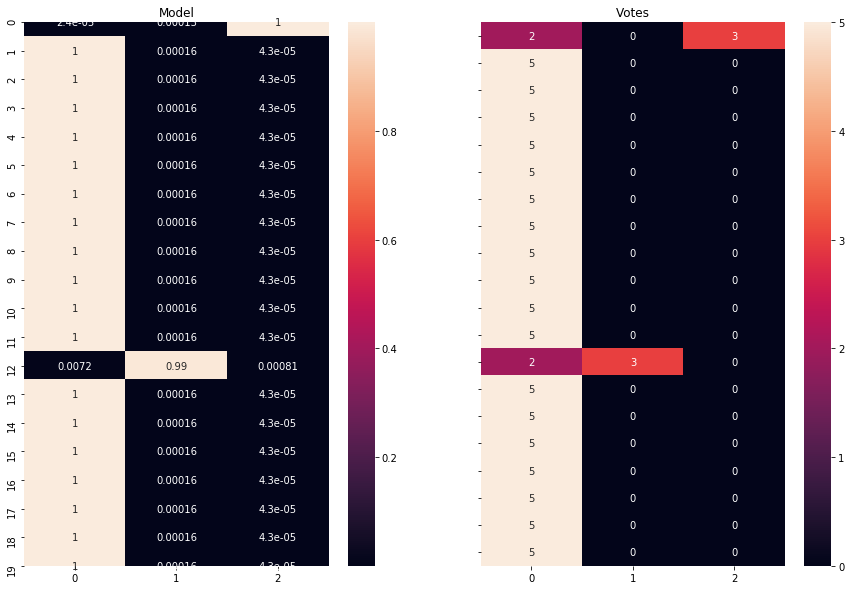

In [168]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

Not as many many ties to break! So maybe bad model bad in a systematic way....?

Let's try everything again with ModelBt

In [169]:
model = ModelBt.create_initial_state(3, 5)
model.map(anno.annotations)
posterior = model.infer_labels(anno.annotations)

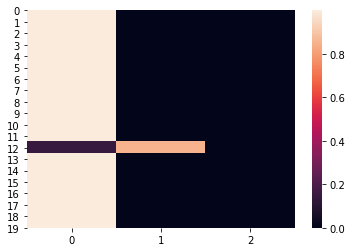

In [170]:
ax = seaborn.heatmap(posterior[:20,])
plt.show()

In [172]:
model = ModelBt.create_initial_state(3, 5)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

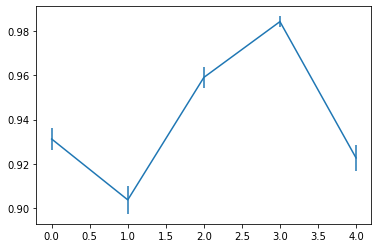

In [174]:
plt.figure()
plt.errorbar(range(5),y, yerr = y_ci)
plt.show()

**Tree** and **Boosting Gradient** which perform pretty bad (from HW3) are evaluated as very accurate!!! This is not a good result to see :(

## Conclusion
* We can use agreement measures to explore how different models agree on extrapolation the same way we measure agreement among annotators!
* However, it is probably not a good idea to treat extrapolations by models the same way as we treat coding by human annotators when we want to choose the final, best values from extrapolations.
    * These methods don't seem to be able to favor models with best performances according to train-test sessions. 
    * It is likely that bad models are bad in systematic ways. If there are more bad models, then we will get a bad, final values.